# Import libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import sklearn

# Read dataset

In [7]:
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader

# class MLPDataset(Dataset):
#     def __init__(self, csv_file):
#         self.data = pd.read_csv(csv_file)
#     def __len__(self):
#         return len(self.data)
#     def __getitem__(self, idx):
#         feature = self.data.iloc[idx, 0:-1]
#         label = self.data.iloc[idx, -1]
#         return feature, label

# data_train = MLPDataset("data_train.csv")
# MLP_dataloader = DataLoader(data_train, batch_size = 10, shuffle=False)

# data_train = pd.read_csv("data_train.csv")
# data_val = pd.read_csv("data_val.csv")
# data_test = pd.read_csv("data_test.csv")
data_train = pd.DataFrame(np.fromfile('data_train.dat', dtype=np.float32).reshape((-1, 824)))
data_val = pd.DataFrame(np.fromfile('data_val.dat', dtype=np.float32).reshape((-1, 824)))
data_test = pd.DataFrame(np.fromfile('data_test.dat', dtype=np.float32).reshape((-1, 824)))
X_training = data_train.iloc[:, 0:-1]
y_training = data_train.iloc[:, -1]
X_val = data_val.iloc[:, 0:-1]
y_val = data_val.iloc[:, -1]
X_test = data_test.iloc[:, 0:-1]
y_test = data_test.iloc[:, -1]

# MLP regression model

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_digits
from tqdm import tqdm

In [9]:
class MLP(nn.Module): #model activation layer change!!!!==========
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self, width):
        super().__init__() 
        torch.manual_seed(0) #setseed

        layer_list = []
        layer_list.append(nn.Linear(823, pow(2,width))) #expand to 2^width features
        layer_list.append(nn.ReLU())

        width_lay = width
        for i in range(6,width):
            layer_list.append(nn.Linear(pow(2,width_lay), pow(2,width_lay-1)))
            layer_list.append(nn.ReLU())
            width_lay -= 1
        layer_list.append(nn.Linear(64, 1))  # regression output
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.layers(x)

## Define utils functions

In [11]:
def fit_and_evaluate(net, optimizer, loss_func, train, val, n_epochs, batch_size=1):
    '''
    Fits the neural network using the given optimizer, loss function, training set
    Arguments:
        net: the neural network
        optimizer: a optim.Optimizer used for some variant of stochastic gradient descent
        train: a torch.utils.data.Dataset
        test: a torch.utils.data.Dataset
        n_epochs: the number of epochs over which to do gradient descent
        batch_size: the number of samples to use in each batch of gradient descent

    Returns:
        train_epoch_loss, test_epoch_loss: two arrays of length n_epochs+1,
        containing the mean loss at the beginning of training and after each epoch
    '''
    # Prepare data
    train_dl = torch.utils.data.DataLoader(train, batch_size)       
    val_dl = torch.utils.data.DataLoader(val)

    train_losses = []
    val_losses = []

    # Compute the loss on the training and validation sets at the start,
    # being sure not to store gradient information (e.g. with torch.no_grad():)
    net.eval()
    with torch.no_grad():
        train_losses.append(epoch_loss(net, loss_func, train_dl))
        val_losses.append(epoch_loss(net, loss_func, val_dl))
        
    # Train the network for n_epochs, storing the training and validation losses
    # after every epoch. Remember not to store gradient information while calling
    # epoch_loss
    for epoch in tqdm(range(n_epochs)):
        #training
        net.train()
        for iteration, (xb, yb) in enumerate(train_dl):
            train_batch(net, loss_func, xb, yb, opt=optimizer)
        #testing
        net.eval()
        with torch.no_grad():
            train_losses.append(epoch_loss(net, loss_func, train_dl))
            val_losses.append(epoch_loss(net, loss_func, val_dl))

        # save checkpoint!=================================================
        # if ((epoch%1) == 0):
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': net.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'loss': [train_losses, val_losses],
        #         }, './checkpoint/checkpoint_epoch_%s'%epoch)
        
    return train_losses, val_losses

def train_batch(net, loss_func, xb, yb, opt=None):
    ''' 
    @param net: the neural network
    @param loss_func: the loss function (can be applied to model(xb), yb)
    @param xb: a batch of the training data to input to the model
    @param yb: a batch of the training labels to input to the model
    @param opt: a torch.optimizer.Optimizer used to improve the model.
    '''
    # Zero the gradients
    opt.zero_grad()  
    # Perform forward pass
    yi = net(xb)
    # Compute loss
    loss = loss_func(yi, yb) 
    # Perform backward pass
    loss.backward()
    # Perform optimization
    opt.step()

def torch_datap(feature_col, label): 
    feature_t = torch.tensor(feature_col.values, dtype=torch.float)
    label_t = torch.tensor(label.values, dtype=torch.float)
    datap = torch.utils.data.TensorDataset(feature_t, label_t)
    return datap

def epoch_loss(net, loss_func, data_loader):
    ''' Computes the average loss of the model on the entire dataset
    @param net: The neural network to be evaluated
    @param loss_func: The loss function used to evaluate the neural network
    @param data_loader: The DataLoader which loads minibatches of the dataset
    @return The network's average loss over the dataset.
    '''
    total_examples = 0
    losses = []
    for X, Y in data_loader:
        total_examples += len(X)
        losses.append(loss_func(net(X), Y).item() * len(X)) # Compute total loss for batch

    return torch.tensor(losses).sum() / total_examples

In [12]:
# Prepare dataset 
# print(X_training.iloc[0:10,:].shape, y_training.iloc[0:10].shape)
test_size = 100
training_p = torch_datap(X_training.iloc[0:test_size,:], y_training.iloc[0:test_size])
valid_p = torch_datap(X_val.iloc[0:test_size,:], y_val.iloc[0:test_size])
# training_p = torch_datap(X_training, y_training)
# valid_p = torch_datap(X_val, y_val)

# Initialize model, optimizer, loss_func
model = MLP(width=10) #change width!===============================================================================
print(model)
optimizer=torch.optim.SGD( model.parameters(), lr=0.005, momentum=0 ) #change lr, momentum, ADAM!==================
loss_func=nn.L1Loss() #change loss!================================================================================

# Initialize batch size and epochs #change!========================================================================
n_epochs=1
batch_size=10

# fit and evaluate, save the best checkpoint
train_losses, val_losses = fit_and_evaluate(model, optimizer, loss_func, training_p, valid_p, n_epochs, batch_size)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=823, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)


/Users/laiyihui/anaconda3/envs/stat_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/laiyihui/anaconda3/envs/stat_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 1/1 [00:32<00:00, 32.52s/it]


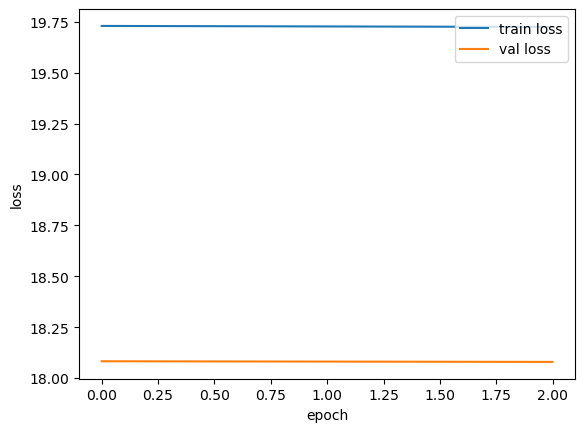

In [14]:
# plotting outcomes
epoch = torch.linspace(0,n_epochs+1,len(train_losses))
plt.plot(epoch, train_losses)
plt.plot(epoch, val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'],loc='upper right')
plt.show()

In [ ]:
# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']